# Red Convolucional en PyTorch

## Librería [`torchvision`](https://pytorch.org/vision/stable/index.html)

Es una librería utilitaria de PyTorch que facilita considerablemente el trabajo con imágenes. Algunas de las funciones y clases que provee:

- Funcionalidad para descargar sets de benchmark: MNIST, CIFAR, IMAGENET, ...
- Modelos clásicos pre-entrenados: AlexNet, VGG, GoogLeNet, ResNet
- Funciones para importar imágenes en distintos formatos
- Funciones de transformación para hacer aumentación de datos en imágenes


**Ejemplo:** Base de datos de imágenes de dígitos manuscritos MNIST

- Imágenes de 28x28 píxeles en escala de grises
- Diez categorías: Dígitos manuscritos del cero al nueve
- 60.000 imágenes de entrenamiento, 10.000 imágenes de prueba
- Por defecto las imágenes vienen en [formato PIL](https://pillow.readthedocs.io/en/stable/) (entero 8bit), usamos la transformación [`ToTensor()`](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.ToTensor) para convertirla a tensor en float32


In [1]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

mnist_train_data = MNIST(root='~/datasets/', train=True, download=True, 
                         transform=transforms.ToTensor())

mnist_test_data = MNIST(root='~/datasets/', train=False, download=True, 
                        transform=transforms.ToTensor())

image, label = mnist_train_data[0]
display(len(mnist_train_data), type(image), image.dtype, type(label))

60000

torch.Tensor

torch.float32

int

A continuación se muestran 10 imágenes aleatorias de MNIST junto a sus etiquetas:

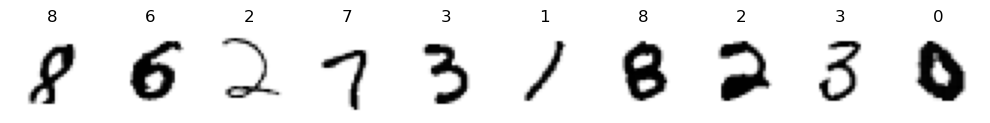

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 10, figsize=(10, 2), tight_layout=True)
idx = np.random.permutation(len(mnist_train_data))[:10]

for k in range(10):
    image, label = mnist_train_data[idx[k]]
    ax[k].imshow(image[0, :, :].numpy(), cmap=plt.cm.Greys)
    ax[k].axis('off');
    ax[k].set_title(label)

## Capas de una red convolucional

Las capas que le dan su nombre a esta arquitectura son las [capas convolucionales](https://pytorch.org/docs/stable/nn.html#convolution-layers). En estas capas:

- Las neuronas de estas capas se organizan en filtros 
- Se realiza la correlación cruzada entre la imagen de entrada y los filtros
- Existen capas convolucionales 1D, 2D y 3D

:::{seealso}

[Visualización de convoluciones con distintos tamaños, strides, paddings, dilations](https://github.com/vdumoulin/conv_arithmetic)

:::

Los argumentos de la capa convolución de dos dimensiones son:

```python
torch.nn.Conv2d(in_channels, #Cantidad de canales de la imagen de entrada
                out_channels, #Cantidad de bancos de filtro
                kernel_size, #Tamaño de los filtros (entero o tupla)
                stride=1, #Paso de los filtros
                padding=0, #Cantidad de filas y columnas para agregar a la entrada antes de filtrar
                dilation=1, #Espacio entre los pixeles de los filtros
                groups=1, #Configuración cruzada entre filtros de entrada y salida
                bias=True,  #Utilizar sesgo (b)
                padding_mode='zeros' #Especifica como agregar nuevas filas/columnas (ver padding)
                )
```

En el siguiente ejemplo se crea una capa convolucional con tres filtros de tamaño 3x3. Luego se muestra el resultado de aplicar los filtros a una imagen de ejemplo de MNIST.

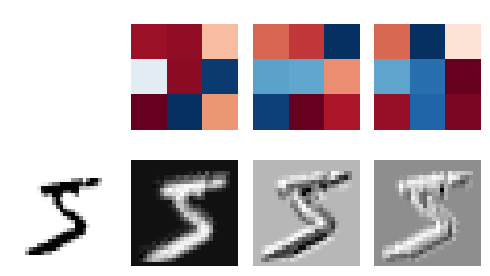

In [3]:
import torch.nn as nn

conv_layer = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3)

example_image = mnist_train_data[0][0]
result = conv_layer(example_image)
example_image.shape, result.shape

fig, ax = plt.subplots(2, 4, figsize=(5, 3), tight_layout=True)
ax[1, 0].matshow(example_image[0], cmap=plt.cm.Greys)
ax[0, 0].axis('off')
ax[1, 0].axis('off')
for ax_, conv_filter in zip(ax[0, 1:], conv_layer.weight.detach().numpy()):
    ax_.matshow(conv_filter[0], cmap=plt.cm.RdBu)
    ax_.axis('off')
    
for ax_, filtered_image in zip(ax[1, 1:], result.detach().numpy()):
    ax_.matshow(filtered_image, cmap=plt.cm.Greys)
    ax_.axis('off')

:::{note}

Cada filtro resalta partes distintas de la imagen. Los pesos de los filtros se aprenden junto a la red neuronal.

:::

Las [capas de pooling](https://pytorch.org/docs/stable/nn.html#pooling-layers) son capas que reducen la dimensión (tamaño) de su entrada

Se usa tipicamente luego de una capa de convolución "activada" y realiza una operación no entrenable: 

Por ejemplo:

- Promedio de los píxeles en una región (kernel_size=2, stride=2)

        1 2 1 0
        2 3 1 2      2.00 1.00
        0 1 0 1      0.75 0.25
        2 0 0 0

- Máximo de los pixeles en una región (kernel_size=2, stride=2)

        1 2 1 0
        2 3 1 2      3 2
        0 1 0 1      2 1
        2 0 0 0

Estas capas ayudan a reducir la complejidad del modelo y también otorgan "invarianza local a la traslación", es decir que la posición donde estaba el patrón es menos relevante luego de aplicar pooling

Los argumentos de MaxPooling para entradas de dos dimensiones son:

```python
torch.nn.MaxPool2d(kernel_size, # Mismo significado que en Conv2d
                   stride=None, # Mismo significado que en Conv2d
                   padding=0, #Mismo significado que en Conv2d
                   dilation=1, #Mismo significado que en Conv2d
                   return_indices=False, #Solo necesario para hacer unpooling
                   ceil_mode=False #Usar ceil en lugar de floor para calcular el tamaño de la salida
                  )
```

Las [capas completamente conectadas](https://pytorch.org/docs/stable/nn.html#torch.nn.Linear) también se utilizan en redes convolucionales. En general son las que se encargan de clasificar el resultado de los filtros convolucionales. A continuación veremos un esquema típico de arquitectura de red convolucional.




## Arquitectura Lenet5

La siguiente figura muestra la clásica arquitectura Lenet5.

<img src="img/LeNet5.png" width="800">

La arquitectura considera:

- Dos capas convolucionales con 6 y 16 bancos de filtros, respectivamente
- Las capas convolucionales usan filtros de 5x5 píxeles
- Se usa max-pooling de tamaño 2x2 y stride 2
- La primera capa convolucional espera un minibatch de imágenes de 1 canal (blanco y negro)
- Usaremos la función de activación [Rectified Linear Unit (ReLU)](https://pytorch.org/docs/stable/nn.html#relu)
- Se usan tres capas completamente conectadas con 120, 84 y 10 neuronas, respectivamente

> Podemos usar `reshape` o `view` para convertir un tensor de 4 dimensiones a dos dimensiones.  Esto prepara un tensor que sale de una capa convolucional (o pooling) para ingresarlo a las capas completamente conectadas.

A continuación se muestra una implementación en pytorch:

In [4]:
import torch.nn as nn

class Lenet5(nn.Module):
    
    def __init__(self):
        super(type(self), self).__init__()
        # La entrada son imágenes de 1x32x32
        self.features = nn.Sequential(nn.Conv2d(1, 6, 5, padding=2),
                                      nn.ReLU(),
                                      nn.MaxPool2d(2),
                                      nn.Conv2d(6, 16, 5),
                                      nn.ReLU(),
                                      nn.MaxPool2d(2))
        
        self.classifier = nn.Sequential(nn.Linear(16*5*5, 120),
                                        nn.ReLU(),
                                        nn.Linear(120, 84),
                                        nn.ReLU(),
                                        nn.Linear(84, 10))

    def forward(self, x):
        z = self.features(x)
        # Esto es de tamaño Mx16x5x5
        z = z.view(-1, 16*5*5)
        # Esto es de tamaño Mx400
        return self.classifier(z)
    
    
model = Lenet5()
print(model)

Lenet5(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


## Clasificación de dígitos manuscritos con Lenet 5

Entrenaremos el modelo Lenet5 para clasificar los dígitos de MNIST. En primer lugar creamos dataloaders de entrenamiento y validación como hemos visto anteriormente:


In [5]:
import torch
import torch.utils.data as tdata

mnist_train, mnist_valid = tdata.random_split(mnist_train_data, [50_000, 10_000], 
                                              generator=torch.Generator().manual_seed(1234))
train_loader = tdata.DataLoader(mnist_train, shuffle=True, batch_size=64)
valid_loader = tdata.DataLoader(mnist_valid, shuffle=False, batch_size=512)

Luego creamos una instacia del mdoelo, el optimizador y la función de costo. Se implementan funciones utilitarias para aplicarse sobre los *minibatches* de entrenamiento y validación. 

Si tenemos acceso a una GPU podemos usar el atributo `.cuda()` o `.to()` para enviar el modelo y los datos a la GPU para acelerar los cálculos.

In [6]:
def train_one_step(batch):
    optimizer.zero_grad()
    data, labels = batch
    data, labels = data.to(device), labels.to(device)
    preds = model.forward(data)
    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item() 

def evaluate_one_step(batch):
    with torch.no_grad():
        data, labels = batch
        data, labels = data.to(device), labels.to(device)
        preds = model.forward(data)
        loss = criterion(preds, labels)
        return loss.item()
    
def train_one_epoch(epoch):    
    train_loss, valid_loss = 0.0, 0.0    
    for batch in train_loader:
        train_loss += train_one_step(batch)    
    for batch in valid_loader:
        valid_loss += evaluate_one_step(batch)
        
    global best_valid_loss    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save({'epoca': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': valid_loss}, 
                   'best_model.pt')

    return train_loss/len(train_loader.dataset), valid_loss/len(valid_loader.dataset)


from tqdm.notebook import tqdm

model = Lenet5()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(reduction='sum')

device = torch.device('cpu')
#device = torch.device('cuda:0')
model = model.to(device)

max_epochs, best_valid_loss = 15, np.inf
running_loss = np.zeros(shape=(max_epochs, 2))
for epoch in tqdm(range(max_epochs)):
    running_loss[epoch] = train_one_epoch(epoch)

  0%|          | 0/15 [00:00<?, ?it/s]

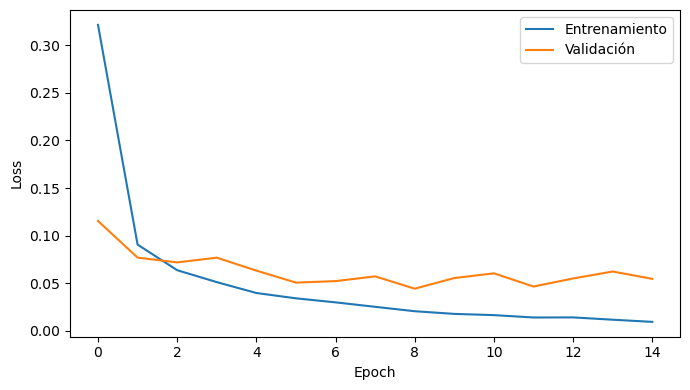

In [7]:
fig, ax = plt.subplots(figsize=(7, 4), tight_layout=True)
ax.plot(running_loss[:, 0], label='Entrenamiento')
ax.plot(running_loss[:, 1], label='Validación')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend();

## Analizando las predicciones del modelo convolucional

Primero recuperamos la red con menor costo de validación

In [8]:
model = Lenet5()
model.load_state_dict(torch.load('best_model.pt')['model_state_dict'])

<All keys matched successfully>

Haremos la evaluación final del a red en el conjunto de prueba/test

Iteramos sobre el conjunto y guardamos las predicciones de la red

In [9]:
test_loader = tdata.DataLoader(mnist_test_data, shuffle=False, batch_size=512)
test_targets = mnist_test_data.targets.numpy()
prediction_test = []
for mbdata, label in test_loader:
    logits = model(mbdata).detach()
    prediction_test.append(logits.argmax(dim=1).numpy())
prediction_test = np.concatenate(prediction_test)

Con esto podemos construir una matriz de confusión y un reporte usando las herramientas de `sklearn`

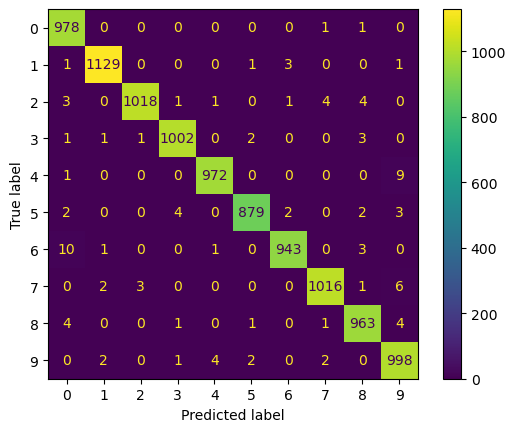

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

ConfusionMatrixDisplay.from_predictions(test_targets, prediction_test);

In [11]:
print(classification_report(test_targets, prediction_test, digits=3))

              precision    recall  f1-score   support

           0      0.978     0.998     0.988       980
           1      0.995     0.995     0.995      1135
           2      0.996     0.986     0.991      1032
           3      0.993     0.992     0.993      1010
           4      0.994     0.990     0.992       982
           5      0.993     0.985     0.989       892
           6      0.994     0.984     0.989       958
           7      0.992     0.988     0.990      1028
           8      0.986     0.989     0.987       974
           9      0.977     0.989     0.983      1009

    accuracy                          0.990     10000
   macro avg      0.990     0.990     0.990     10000
weighted avg      0.990     0.990     0.990     10000



Luego de evaluar la red el siguiente paso es **estudiar sus errores**. Para problemas con imágenes es muy recomendable visualizar los ejemplos mal predichos por la red

Esto podría revelar

- Imágenes mal etiquetadas: Podemos cambiar su etiqueta y re-entrenar/re-evaluar
- Errores sistemáticos del modelo: Por ejemplo que siempre se equivoque con una clase u objeto en particular

Observemos algunos ejemplos mal clasificados

- Las imágenes corresponden a `digit` que no fueron predichos como `digit`
- El título de la imagen tiene la predicción por la red

Veamos 10 ejemplos erroneos para tres clases particulares:

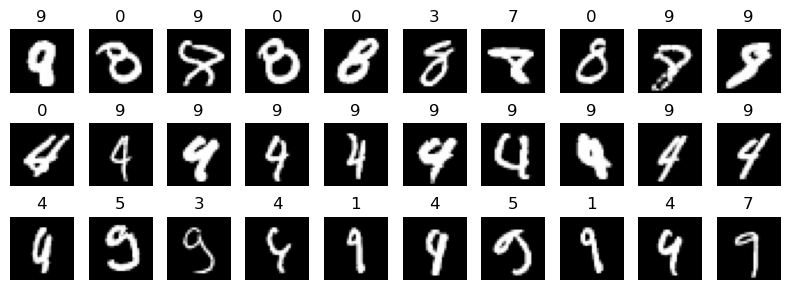

In [12]:
fig, ax = plt.subplots(3, 10, figsize=(8, 3), tight_layout=True)

for k, digit in enumerate([8, 4, 9]):    
    idx = np.where((test_targets == digit) & ~(prediction_test == digit))[0]
    for i in range(10):
        ax[k, i].axis('off')
        if i < len(idx):
            ax[k, i].set_title(prediction_test[idx[i]])
            ax[k, i].imshow(mnist_test_data[idx[i]][0].numpy()[0, :, :], cmap=plt.cm.Greys_r)
    

**Reflexión** Según la forma de los dígitos ¿tienen sentido estos errores? Discuta con sus compañeros.